<a href="https://colab.research.google.com/github/Hardik-S/Horse-Recognition/blob/master/HorseIdentifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports


In [0]:
from fastai.vision import *


##Folder Creation

Upload .txt files after using google to find images of xyz. Scroll to bottom, Ctrl+Shift+J, disable uBlock, paste:  
```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

Loops through and automatically creates folders and downloads URL text files downloaded locally earlier.

In [0]:
i=0
while (i<3):
  print (i)
  if (i==0):
    folder = 'mustangs'
    file = 'mustangs.txt'
  
  if (i==1):
    folder = 'arabians'
    file = 'arabians.txt'
  
  if (i==2):
    folder = 'unicorns'
    file = 'unicorns.txt'

  #run always
  
  #Path block
  path = Path('data/horses')
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)
  #Download block
  download_images(path/file, dest, max_pics=50, max_workers=0)
  i = i+1

0


1


2


In [0]:
classes = ['mustangs','arabians','unicorns']

In [0]:
path.ls()

[PosixPath('data/horses/arabians'),
 PosixPath('data/horses/export.pkl'),
 PosixPath('data/horses/unicorns'),
 PosixPath('data/horses/mustangs.txt'),
 PosixPath('data/horses/arabians.txt'),
 PosixPath('data/horses/mustangs'),
 PosixPath('data/horses/mustangS'),
 PosixPath('data/horses/models'),
 PosixPath('data/horses/cleaned.csv'),
 PosixPath('data/horses/unicorns.txt')]

In [0]:
#prunes false images
for c in classes:
  print(c)
  verify_images(path/c, delete=True, max_size=500)

mustangs


arabians


unicorns


##View Data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['arabians', 'mustangs', 'unicorns']

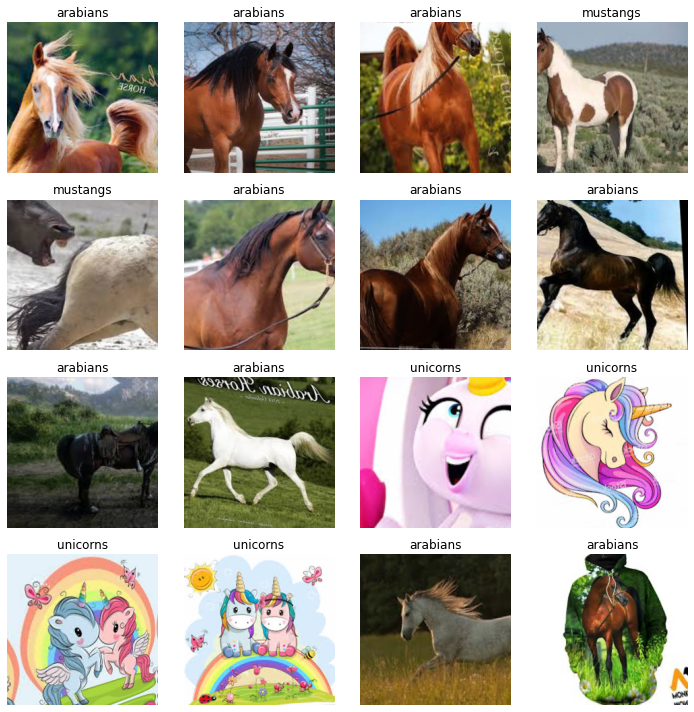

In [0]:
data.show_batch(rows=4, figsize=(10,10))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['arabians', 'mustangs', 'unicorns'], 3, 120, 30)

##Train Model


In [0]:
myLearner = cnn_learner(data, models.resnet34, metrics=accuracy)

In [0]:
myLearner.fit_one_cycle(4)
myLearner.save('phase-1')

epoch,train_loss,valid_loss,accuracy,time
0,2.528969,1.815159,0.466667,00:21
1,2.197233,1.005383,0.666667,00:22
2,1.654259,0.936767,0.833333,00:21
3,1.356984,0.914759,0.800000,00:21


Here, accuracy varies. I don't want to overfit by exceeding 4 epochs but 70% isn't very convincing. The low sample train size (30 pictures) is the primary limiting factor, but this is a proof of concept so - lets roll with it and fit it later.

In [0]:
myLearner.unfreeze()

In [0]:
myLearner.lr_find(start_lr=1e-4, end_lr=1e-2)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

In [0]:
#??lr_find


In [0]:
myLearner.recorder.plot()

In [0]:
myLearner.fit_one_cycle(4,max_lr=slice(3e-5,3e-4))
myLearner.save('phase-2')

Increasing to ~90% accuracy after fitting here is very promising.

##Interpretation

In [0]:
myLearner.load('phase-2');

In [0]:
interp = ClassificationInterpretation.from_learner(myLearner)

In [0]:
interp.plot_confusion_matrix()

Unfortunately, we're messing up more than I had initially hoped. Fortunately, the messing up isn't awfully biased.

##Clean Up

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [0]:
myLearner_cln = cnn_learner(db, models.resnet34, metrics=accuracy)

myLearner_cln.load('phase-2');

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(myLearner_cln)

Using this widget created by Jeremy Howard's team to clean up any false images. 

In [0]:
ImageCleaner(ds, idxs, path)

In [0]:
ds, idxs = DatasetFormatter().from_similars(myLearner_cln)

Clean up any duplicates that may be affecting the data. Fortunately, all of the google images were at least from a different angle / colour.

In [0]:
ImageCleaner(ds, idxs, path, duplicates=True)

##Export

In [0]:
myLearner.export()

In [0]:
defaults.device = torch.device('cpu')

In [0]:
img = open_image(path/'unicorns'/'00000021.jpg')
img

In [0]:
myLearner = load_learner(path)

In [0]:
pred_class,pred_idx,outputs = myLearner.predict(img)
pred_class